In [13]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

In [14]:
# plotting style, overrides ide themes
plt.style.use("default")

# constants
AVOGADRO = 6.02*(10**23)  # atoms/mol
WEIGHT_ATOMIC_CO2 = 12  # g/mol
DENSITY_GRAPHITE = 2.25  # g/cm^3
UNCERTAINTY_RULER = 0.05  # mm

in_pickle = open('lab03/data/readings.pkl', 'rb')
# data (ndarray) = [[sample_voltage,inner_diameter,outer_diameter],..]
main_data = pickle.load(in_pickle)

# enums for indexing into main_data
SAMPLE_VOLTAGES = 0
INNER_DIAMETER = 1
OUTER_DIAMETER = 2

In [21]:
# convert mm -> m units
conversionFactor = 1/(10*100)
for i in [INNER_DIAMETER, OUTER_DIAMETER]:
    main_data[:,i] *= conversionFactor
# update measurement uncertainty
UNCERTAINTY_RULER *= conversionFactor

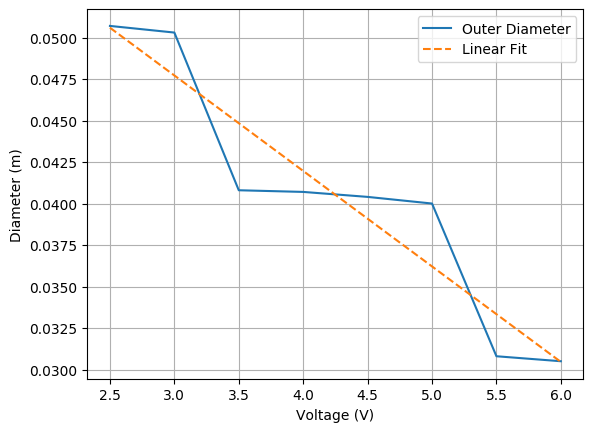

In [16]:
# Sample Voltage vs. Outer Diameter
plt.plot(main_data[:,SAMPLE_VOLTAGES], main_data[:,OUTER_DIAMETER], label="Outer Diameter")
plt.xlabel("Voltage (V)")
plt.ylabel("Diameter (m)")
plt.grid(True)

# linear fit: https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
vRange = np.arange(2.5, 6.1, 0.5)
outerFit = np.polyfit(main_data[:,SAMPLE_VOLTAGES], main_data[:,OUTER_DIAMETER], deg=1, full=True)
plt.plot(vRange, outerFit[0][0]*vRange + outerFit[0][1], "--", label="Linear Fit")

plt.legend()
plt.show()

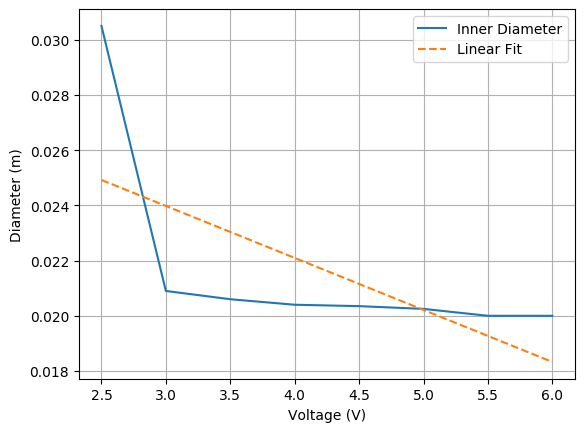

In [17]:
# Sample Voltage vs. Inner Diameter
plt.plot(main_data[:,SAMPLE_VOLTAGES], main_data[:,INNER_DIAMETER], label="Inner Diameter")
plt.xlabel("Voltage (V)")
plt.ylabel("Diameter (m)")
plt.grid(True)

# linear fit: https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
vRange = np.arange(2.5, 6.1, 0.5)
innerFit = np.polyfit(main_data[:,SAMPLE_VOLTAGES], main_data[:,INNER_DIAMETER], deg=1, full=True)
plt.plot(vRange, innerFit[0][0]*vRange + innerFit[0][1], "--", label="Linear Fit")

plt.legend()
plt.show()